In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201128


Use some data

In [2]:
import pickle
for dataset in [#'biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0].astype(int)
    print(dataset)
    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()}")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0]
    X=X.astype(int)

    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()} ==> d={X.max()+1}")
    d = X.max()+1
    return X, d

flare
	data shape: (1065, 13)
	range of X values: 0 -- 7
lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7
spect
	data shape: (187, 23)
	range of X values: 0 -- 1
tumor
	data shape: (339, 17)
	range of X values: 0 -- 3
votes
	data shape: (435, 17)
	range of X values: 0 -- 2


In [3]:
dataset = 'lymphography'
print("dataset:", dataset)
X,d = load_dataset(dataset)

D = 4
mps       = PosMPS(X, d, D, homogeneous=False)
mps_hom   = PosMPS(X, d, D, homogeneous=True)

rBorn     = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 

cBorn     = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)

rBorn_s   = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 

cBorn_s   = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)

models     = (rBorn, cBorn, rBorn_s, cBorn_s, mps)
models_hom = (rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom)
print("Initializing models:")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for p in model.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")

dataset: lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7 ==> d=8
Initializing models:
	torch.Size([19, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous
	torch.Size([19, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous
	torch.Size([19, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([19, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([19, 8, 4, 4]) model type: Positive MPS, Non-homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([8, 4, 4]) model type: Positive MPS, Homogeneous


In [4]:
def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.SGD(self.parameters(), **optim_kwargs)
    early_stopping_threshold = 0.0001 # min difference in epoch loss
    loss_values = [] # store by-epoch avg loss values
    print('╭───────────────────────────')
    print(f"│Training {self.name}.")
    av_batch_loss_running = -1000
    with tqdm(range(max_epochs), leave=True) as tepochs:
        for epoch in tepochs:
    #         print("epoch", epoch)
            batch_loss = []
            with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
                for batch in tepoch:
                    for p in self.parameters():
                        if torch.isnan(p).any():
                            print(" loss values:", *(f"{x:.3f}" for x in loss_values))
                            print("└────Stopped. Model weights contain a NaN value!")
                            if plot:
                                plt.plot(loss_values)
                                plt.show()
                            return loss_values
                    self.zero_grad()
                    neglogprob = 0
                    for i,x in enumerate(batch):
                        out = self(x)
                        neglogprob -= out
                    loss = neglogprob / len(batch)
                    loss.backward()
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    with torch.no_grad():
                        batch_loss.append(loss.item())
    #                     n=5
    #                     if batch_idx % n == 0: # print every nth batch loss
    #                         print("\tbatch", batch_idx, "size", len(batch), "loss", loss.item())
            av_batch_loss = torch.Tensor(batch_loss).mean().item()
    #         print(f"ep{epoch} av_batch_loss\t {av_batch_loss}")
            loss_values.append(av_batch_loss)
            tepochs.set_postfix(av_batch_loss=av_batch_loss)
            if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
                print("└────Early stopping.")
                break
            av_batch_loss_running = av_batch_loss
    print(" loss values:", *(f"{x:.3f}" for x in loss_values))
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('╰────────Finished─training──\n')
    return loss_values

# train(rBorn, X, batchsize=30, max_epochs = 10, lr=0.1)

╭───────────────────────────
│Training Born (torch.float32), Homogeneous.



 loss values: 34.316 27.160 25.743 25.623 25.044 24.822 24.350 23.906 23.453 23.267 23.230 23.673 23.013 22.849 22.792 23.091 22.648 22.753 22.605 22.761 22.394 22.594 22.625 22.459 22.124 21.883 22.129 22.030 21.971 21.872 21.939 21.564 21.643 21.870 21.611 21.377 21.544 21.569 21.578 21.616 21.552 21.671 21.619 21.358 21.302 21.405 21.432 21.580 21.703 21.361 21.368 21.355 21.010 21.475 21.334 21.359 21.189 21.379 21.337 21.236 21.345 21.116 21.177 21.184 21.068 21.282 21.382 21.040 21.370 21.302 21.292 20.978 21.081 21.046 21.158 21.051 20.831 21.111 20.961 21.030 21.366 21.051 20.947 20.891 20.837 20.793 20.586 20.738 21.262 20.871 20.702 20.745 20.556 20.842 20.572 20.556 20.413 20.695 20.755 20.444
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Born (torch.float32), Homogeneous + log_stability.



 loss values: 32.498 26.572 25.583 25.153 24.588 24.395 24.019 23.417 23.148 22.468 21.842 22.068 21.441 21.511 21.240 21.427 21.175 21.106 20.656 20.635 20.927 20.517 20.560 20.334 20.295 20.042 20.298 20.314 20.284 19.822 19.982 20.094 20.073 19.837 19.782 19.380 19.990 19.370 19.559 19.400 19.454 19.286 19.324 19.145 19.085 18.953 19.160 18.987 18.922 18.925 18.846 18.834 18.638 19.012 18.523 18.567 18.385 18.531 18.771 18.237 18.162 18.030 18.214 18.269 18.050 18.087 17.985 18.117 17.930 18.277 18.072 18.288 17.822 18.062 18.367 17.929 18.128 18.260 18.016 17.791 17.962 17.778 17.870 18.149 17.881 17.815 17.962 17.927 17.888 17.784 18.054 17.759 17.599 17.609 18.145 18.289 17.650 17.696 18.041 19.130
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous + log_stability.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Positive MPS, Homogeneous.



 loss values: 32.409 26.384 25.310 24.588 24.057 23.723 23.331 23.293 23.137 22.921 23.326 23.119 22.852 23.411 22.975 22.554 22.883 22.857 22.603 22.320 22.653 22.687 22.678 22.223 22.649 22.626 22.736 22.657 22.536 22.800 22.381 22.403 22.557 22.478 22.447 22.206 22.236 22.816 22.456 22.083 22.240 21.833 22.225 21.899 22.134 21.948 21.714 22.032 21.982 22.093 21.883 22.171 21.780 22.164 21.933 22.041 21.763 21.722 21.612 21.945 21.741 21.839 21.675 21.758 21.878 21.818 21.696 21.517 21.888 21.978 21.894 21.792 21.964 21.754 21.979 21.634 21.671 21.794 22.060 21.579 21.794 21.861 21.728 22.136 21.517 21.655 21.820 21.636 21.705 21.669 21.813 22.146 21.731 21.892 21.498 21.573 21.864 21.846 21.620 21.663
╰────────Finished─training──



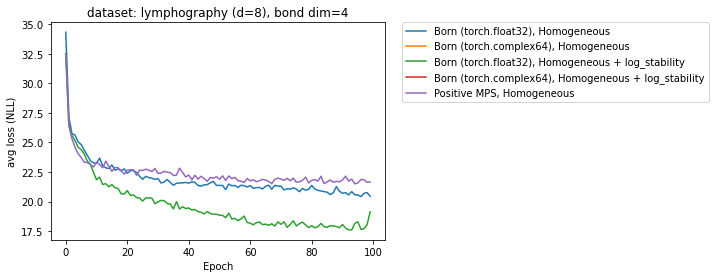

In [5]:
modelhom_loss_values={}
for model in models_hom:
    loss_values = train(model, X, batchsize=35, plot=False, max_epochs = 100, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    modelhom_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous.



 loss values: 22.849 22.272 21.713 21.228 20.770 20.359 19.995 19.638 19.326 19.044 18.779 18.516 18.320 18.095 17.915 17.713 17.564 17.438 17.265 17.132 16.999 16.890 16.792 16.690 16.603 16.505 16.439 16.353 16.292 16.215 16.156 16.115 16.062 15.999 15.953 15.894 15.854 15.810 15.782 15.719 15.701 15.681 15.652 15.598 15.573 15.546 15.528 15.498 15.473 15.452 15.435 15.405 15.402 15.373 15.365 15.363 15.325 15.310 15.293 15.271 15.263 15.254 15.252 15.209 15.202 15.181 15.171 15.155 15.156 15.129 15.135 15.118 15.113 15.088 15.084 15.074 15.068 15.042 15.049 15.037 15.005 14.997 14.998 14.992 14.988 14.969 14.954 14.955 14.937 14.926 14.939 14.937 14.922 14.886 14.884 14.875 14.887 14.866 14.865 14.837
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability.



 loss values: 22.004 21.302 20.697 20.120 19.615 19.143 18.733 18.329 17.997 17.653 17.353 17.086 16.823 16.580 16.380 16.152 15.981 15.816 15.640 15.485 15.356 15.209 15.098 14.976 14.871 14.763 14.679 14.592 14.523 14.417 14.337 14.273 14.216 14.149 14.104 14.018 13.960 13.915 13.875 13.822 13.784 13.742 13.689 13.654 13.631 13.591 13.548 13.512 13.482 13.449 13.414 13.393 13.373 13.349 13.321 13.278 13.259 13.249 13.233 13.188 13.189 13.156 13.128 13.126 13.093 13.095 13.041 13.044 13.025 12.999 12.984 12.965 12.956 12.944 12.915 12.914 12.898 12.874 12.845 12.850 12.836 12.812 12.807 12.783 12.774 12.751 12.734 12.717 12.722 12.697 12.688 12.665 12.655 12.632 12.616 12.605 12.595 12.592 12.573 12.565
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous + log_stability.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Positive MPS, Non-homogeneous.



 loss values: 21.167 20.496 19.908 19.417 18.987 18.612 18.279 17.996 17.749 17.510 17.320 17.155 16.985 16.847 16.723 16.620 16.494 16.410 16.318 16.234 16.164 16.091 16.039 15.969 15.917 15.891 15.829 15.788 15.754 15.732 15.675 15.665 15.630 15.592 15.569 15.535 15.520 15.494 15.473 15.462 15.452 15.413 15.396 15.387 15.363 15.343 15.335 15.318 15.304 15.290 15.278 15.260 15.250 15.238 15.227 15.221 15.208 15.194 15.206 15.163 15.169 15.144 15.168 15.133 15.122 15.114 15.115 15.107 15.090 15.075 15.084 15.062 15.050 15.058 15.053 15.047 15.026 15.021 15.004 15.009 15.004 15.001 14.988 14.981 14.982 14.974 14.985 14.979 14.960 14.949 14.947 14.943 14.947 14.937 14.927 14.927 14.920 14.898 14.908 14.909
╰────────Finished─training──



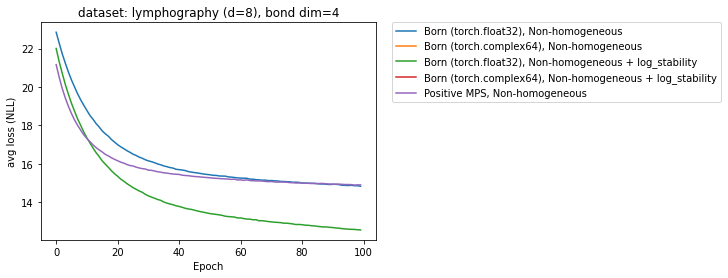

In [7]:
model_loss_values={}
for model in models:
    loss_values = train(model, X, batchsize=30, plot=False, max_epochs = 100, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

---------

In [57]:
# testing complex functions
real = torch.tensor([[1, 2],[2, 1]], dtype=torch.float32)
imag = torch.tensor([[3, 4],[1, 2]], dtype=torch.float32)
z = torch.complex(real, imag)
# z = torch.randn(2,2, dtype=torch.cfloat)
z.requires_grad=True
b = (2.7j*z + 3.4*z + 18)
L = torch.einsum('ij,ji,ij,ji->',b,b,b,b).abs()
L.backward()

print("z:\n",z,'\n', sep='')
print("loss grad_fn:\n", L.grad_fn,'\n', sep='')
print("z.grad:\n", z.grad,'\n', sep='')

def infnorm(tensor):
#     return torch.max(torch.sum(abs(tensor), dim=-1))
    print(tensor.abs().max())
    return torch.linalg.norm(tensor, ord=float('inf')).real

norm = infnorm
print(norm(z.grad))
print(norm(z.grad[0]))

z:
tensor([[1.+3.j, 2.+4.j],
        [2.+1.j, 1.+2.j]], requires_grad=True)

loss grad_fn:

z.grad:
tensor([[103476.6328-38667.7930j, 224180.9375+59425.4219j],
        [219980.8125-67495.4922j, 105286.0781+37877.9062j]])

tensor(231923.4219)
tensor(342388.8438)
tensor(231923.4219)
tensor(231923.4219)


In [20]:
print(matnorm(z))
print(torch.max(torch.sum(abs(z), dim=1)))

tensor(7.6344+0.j, grad_fn=<CopyBackwards>)
tensor(7.6344, grad_fn=<MaxBackward1>)
